# Data processing for "The Rise and Fall of the Note: Changing Paper Lengths in ACM CSCW, 2000-2018"

by R. Stuart Geiger ([@staeiou](http://twitter.com/staeiou)), staff ethnographer, [Berkeley Institute for Data Science](http://bids.berkeley.edu)

Freely licensed under both [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/) and [The MIT License](https://opensource.org/licenses/MIT).

This notebook does almost all of the data processing for the study. Paper PDFs were manually downloaded into `../data/pdfs/YEAR/`, then batch converted to .docx using Adobe Acrobat DC, which are found in `../data/docx/YEAR/`. I tried a number of different approaches using free/open-source software, but due to the age of many of the PDFs in the dataset and Adobe's effective ownership of the PDF format, this was the best way to get consistent results. 

This notebook converts all the .docx files to .txt using `pandoc`, loads the plain text and other metadata into a pandas dataframe, and extracts reference and appendix sections. Two data files are output: `cscw-pages-all.csv` includes the full plain text and is not publicly shared, but `cscw-pages-notext.csv` only contains quantitative metrics. These are analyzed by `analysis-viz.ipynb`. 

Note that this notebook also includes one paper from 2019, the camera-ready version for this study, just for comparison purposes. This paper is not included in the dataset that is used for data analysis and visualization.

I am using a mix of bash commands and python scripts to process and collect the data. Various standard GNU/Linux tools are used that may or may not be available on other OSes, including: `wc`, `find`, `xargs`, as well as `pandoc` (which is not commonly included in Linux OSes). This notebook also uses`imagemagick` via the `Wand` python connector library to display images of PDFs in this notebook for demonstration purposes, but these are not a core requirement of the data processing pipeline.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime
from wand.image import Image as WImage

%matplotlib inline
sns.set(font_scale=2)

In [2]:
start = datetime.datetime.now()

## Number of pages

In [3]:
import glob
from PyPDF2 import PdfFileReader

In [4]:
years = list(range(2010,2019))
years.append(2000)
years.append(2002)
years.append(2004)
years.append(2006)
years.append(2008)
years.append(2017.5)
years.append(2019)
years.sort()
years

[2000,
 2002,
 2004,
 2006,
 2008,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2017.5,
 2018,
 2019]

In [5]:
pages_list = []
for year in years:
    print(year)
    for pdf in glob.glob("../data/pdfs/" + str(year) + "/*.pdf"):
        pdf_obj = PdfFileReader(open(pdf,'rb'), strict=False)
        num_pages = pdf_obj.getNumPages()
        orientation = pdf_obj.getPage(0).get('/Rotate')
        row = {'filename':pdf[13:-4],'year':year,'num_pages':num_pages,'orientation':orientation}
        pages_list.append(row)

2000
2002
2004
2006
2008
2010
2011
2012
2013
2014
2015
2016
2017
2017.5
2018
2019


In [6]:
df_pages = pd.DataFrame(pages_list).set_index('filename')
df_pages[0:5]

,num_pages,orientation,year
filename,,,
2000/p1-boyle,10,0.0,2000.0
2000/p107-litiu,10,0.0,2000.0
2000/p11-jackson,10,0.0,2000.0
2000/p117-roussev,10,0.0,2000.0
2000/p127-he,8,0.0,2000.0


In [7]:
gb = df_pages.groupby('year')
pd.DataFrame(gb['num_pages'].value_counts(sort=False))
#df_pages.num_pages.value_counts()

num_pages
year   num_pages           
2000.0 8                  7
       9                  2
       10                27
2002.0 8                  3
       9                  3
       10                33
2004.0 3                  1
       4                 22
       7                  1
       8                  2
       9                  2
       10                48
2006.0 4                 15
       8                  1
       9                  2
       10                43
2008.0 4                 22
       9                  1
       10                62
       11                 1
2010.0 4                 22
       9                  2
       10                34
2011.0 1                  1
       2                  9
       4                 49
       7                  2
       8                  7
       10                44
2012.0 1                  1
...                     ...
2017.5 18                17
       19                12
       20                 6
       21                19
       22                13
       23                 5
       24                 5
       25                 2
       26                 3
       27                 2
       33                 1
2018.0 12                 1
       15                 2
       16                 6
       17                 3
       18                18
       19                13
       20                17
       21                18
       22                22
       23                21
       24                15
       25                13
       26                10
       27                10
       28                 7
       29                 6
       31                 1
       34                 2
2019.0 10                 1

[131 rows x 1 columns]

Text(0.5, 0.98, 'Boxplots for length of CSCW papers over time')

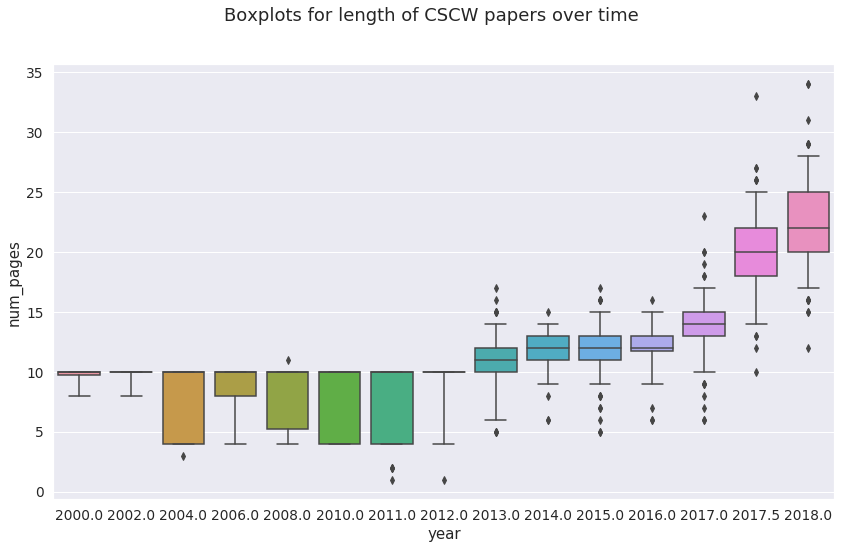

In [8]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=[14,8])
sns.boxplot(data=df_pages.dropna().query("orientation == 0"), y='num_pages', x='year', whis=[5,95], ax=ax)
plt.suptitle("Boxplots for length of CSCW papers over time")

In [9]:
end = datetime.datetime.now()

time_to_run = end - start
minutes = int(time_to_run.seconds/60)
seconds = time_to_run.seconds % 60
print("Current runtime: ", minutes, "minutes, ", seconds, "seconds")

Current runtime:  0 minutes,  21 seconds


## Process docx to text

In [10]:
!unzip -o ../data/docx/corrected.zip -d ../data/docx

Archive:  ../data/docx/corrected.zip
  inflating: ../data/docx/2004/p192-bardram.docx  
  inflating: ../data/docx/2008/p559-christensen.docx  
  inflating: ../data/docx/2014/p134-steinhardt.docx  
  inflating: ../data/docx/2014/p733-ehrlich.docx  
  inflating: ../data/docx/2015/p1139-coetzee.docx  
  inflating: ../data/docx/2015/p1277-eschler.docx  
  inflating: ../data/docx/2016/26_ichino.docx  
  inflating: ../data/docx/2016/466_arif.docx  
  inflating: ../data/docx/2016/648_leavitt.docx  
  inflating: ../data/docx/2017.5/a064-kumar.docx  
  inflating: ../data/docx/2017/p126-mitra.docx  
  inflating: ../data/docx/2017/p480-poretski.docx  
  inflating: ../data/docx/2018/cscw124-miller-hillberg.docx  
  inflating: ../data/docx/2018/cscw133-panger.docx  
  inflating: ../data/docx/2018/cscw194-zhu.docx  


The following bash command converts all the .docx files to .txt using `pandoc` and `xargs` to parallelize. The number of threads is set with the -P flag, you might want to change from -P8 to the number of CPUs you have.

In [11]:
!find ../data/docx/ -name "*.docx" -print0 | xargs -0 -n2 -P8 -I{} pandoc {} -t plain -o {}.txt

In [12]:
end = datetime.datetime.now()

time_to_run = end - start
minutes = int(time_to_run.seconds/60)
seconds = time_to_run.seconds % 60
print("Current runtime: ", minutes, "minutes, ", seconds, "seconds")

Current runtime:  5 minutes,  46 seconds


In [13]:
# This command replaces all punctuation with spaces, which I ended up not choosing to do.

#!find ../data/docx/ -name "*.docx.txt" -exec sed -i 's/[[:punct:]]/ /g' {} \;


In [14]:
!rm -rf ../data/txt
!mkdir ../data/txt

In [15]:
!cp -r ../data/docx/* ../data/txt/

In [16]:
!find ../data/txt/ -name "*.docx" -type f -delete 

The following bash command runs `wc` to get word counts for all papers, although these ended up being discarded for a more consistent word count in python (which does counts for the entire paper and the various sections of the paper). However, this is kept because it is used for indexing. The `head -n -1` cuts off the last line of the `wc` output, which prints a total when there are multiple files. Since there is only one 2019 paper here (this one!), this has to be run separately.

In [17]:
%%bash
rm -rf ../data/word_counts/
mkdir ../data/word_counts/
for year in {2000,2002,2004,2006,2008,{2010..2017},2017.5,2018}
do
    wc -w ../data/txt/$year/*.docx.txt | sed 's/^ *//' | head -n -1 > ../data/word_counts/cscw-$year-pages.csv
done

wc -w ../data/txt/2019/*.docx.txt | sed 's/^ *//' > ../data/word_counts/cscw-2019-pages.csv

In [18]:
!ls ../data/word_counts

cscw-2000-pages.csv  cscw-2011-pages.csv  cscw-2017.5-pages.csv
cscw-2002-pages.csv  cscw-2012-pages.csv  cscw-2017-pages.csv
cscw-2004-pages.csv  cscw-2013-pages.csv  cscw-2018-pages.csv
cscw-2006-pages.csv  cscw-2014-pages.csv  cscw-2019-pages.csv
cscw-2008-pages.csv  cscw-2015-pages.csv
cscw-2010-pages.csv  cscw-2016-pages.csv


In [19]:
!head ../data/word_counts/cscw-2000-pages.csv

6217 ../data/txt/2000/p107-litiu.docx.txt
8303 ../data/txt/2000/p117-roussev.docx.txt
8651 ../data/txt/2000/p11-jackson.docx.txt
5845 ../data/txt/2000/p127-he.docx.txt
10502 ../data/txt/2000/p135-cadiz.docx.txt
7227 ../data/txt/2000/p145-singley.docx.txt
4914 ../data/txt/2000/p155-kuzuoka.docx.txt
4807 ../data/txt/2000/p163-yano.docx.txt
10019 ../data/txt/2000/p171-vidot.docx.txt
8108 ../data/txt/2000/p181-mauve.docx.txt


In [20]:
!head ../data/word_counts/cscw-2018-pages.csv

11640 ../data/txt/2018/cscw017-alvarado-garcia.docx.txt
12684 ../data/txt/2018/cscw018-ames.docx.txt
15910 ../data/txt/2018/cscw019-andalibi.docx.txt
14165 ../data/txt/2018/cscw020-arif.docx.txt
8642 ../data/txt/2018/cscw021-asthana.docx.txt
10857 ../data/txt/2018/cscw022-august.docx.txt
11533 ../data/txt/2018/cscw023-baumer.docx.txt
13216 ../data/txt/2018/cscw024-berenberg.docx.txt
10334 ../data/txt/2018/cscw025-buntain.docx.txt
14266 ../data/txt/2018/cscw026-buyuktur.docx.txt


## Merge dataframes, spot check

In [21]:
df_words = pd.DataFrame(columns=["filename","year", "words"])

for year in years:
    df_year = pd.read_csv("../data/word_counts/cscw-"+ str(year) + "-pages.csv", sep=" ", names=["words", "filename"])
    
    for idx, row in df_year.iterrows():
        df_words = df_words.append({"filename":row['filename'][12:-9], "year": str(year), "words":row['words']}, ignore_index=True)

In [22]:
df_words.words = df_words.words.astype(int)

In [23]:
gb = df_words.groupby("year")
pd.DataFrame(gb.describe())

words                                                                  \
        count          mean          std     min       25%      50%       75%   
year                                                                            
2000     36.0   7734.583333  1639.807521  4807.0   6687.75   7905.5   8702.75   
2002     39.0   8004.205128   934.713893  5945.0   7483.00   8063.0   8559.00   
2004     76.0   7238.263158  2723.627803  2052.0   3901.00   8248.0   9391.00   
2006     61.0   7805.754098  2538.826387  2882.0   7193.00   9126.0   9484.00   
2008     86.0   7074.918605  2444.979366  2428.0   4177.25   8082.5   8776.25   
2010     58.0   6540.603448  2685.134052  2757.0   3423.25   7889.5   8874.50   
2011    112.0   4714.035714  3217.590251   229.0   1589.75   3466.0   8017.75   
2012    165.0   7299.757576  2403.567770   492.0   7282.00   8237.0   8836.00   
2013    139.0   8961.510791  2085.197726  3821.0   7995.00   9189.0  10005.00   
2014    134.0   9793.194030  1685.812972  5182.0   8690.75   9745.0  10767.00   
2015    161.0   9840.695652  1998.101146  3194.0   8677.00   9822.0  10995.00   
2016    140.0  10358.550000  1727.920255  4666.0   9385.75  10303.0  11316.00   
2017    183.0  11367.803279  2225.448409  4693.0  10158.00  11159.0  12489.00   
2017.5  105.0  12322.714286  2271.654335  5868.0  10989.00  12209.0  13769.00   
2018    185.0  13118.140541  2669.746133  6541.0  11503.00  12898.0  14657.00   
2019      1.0   5737.000000          NaN  5737.0   5737.00   5737.0   5737.00   

                 
            max  
year             
2000    11024.0  
2002     9721.0  
2004    10883.0  
2006    10616.0  
2008    11016.0  
2010    10036.0  
2011     9824.0  
2012    11165.0  
2013    16007.0  
2014    14772.0  
2015    15432.0  
2016    16225.0  
2017    19697.0  
2017.5  20744.0  
2018    25369.0  
2019     5737.0

In [24]:
df_words = df_words.set_index('filename')

In [25]:
df_words['year_float'] = df_words['year'].astype(float)

In [26]:
df_words[0:5]

,year,words,year_float
filename,,,
2000/p107-litiu,2000,6217,2000.0
2000/p117-roussev,2000,8303,2000.0
2000/p11-jackson,2000,8651,2000.0
2000/p127-he,2000,5845,2000.0
2000/p135-cadiz,2000,10502,2000.0


In [27]:
df_words.query("year>'2012'").sort_values('words')

,year,words,year_float
filename,,,
2015/p1153-diakopoulos,2015,3194,2015.0
2013/p1481-lee,2013,3821,2013.0
2013/p1285-kinnaird,2013,4053,2013.0
2013/p803-gilbert,2013,4068,2013.0
2013/p471-colineau,2013,4436,2013.0
2013/p1463-robson,2013,4449,2013.0
2013/p753-teevan,2013,4479,2013.0
2013/p1499-saket,2013,4632,2013.0
2015/p1359-vashistha,2015,4658,2015.0


### Character counts

In [28]:
%%bash
rm -rf ../data/char_counts/
mkdir ../data/char_counts/
for year in {2000,2002,2004,2006,2008,{2010..2017},2017.5,2018}
do
    wc -m ../data/txt/$year/*.docx.txt | sed 's/^ *//' | head -n -1 > ../data/char_counts/cscw-$year-pages.csv
done

wc -m ../data/txt/2019/*.docx.txt | sed 's/^ *//' > ../data/char_counts/cscw-2019-pages.csv

In [29]:
!ls ../data/char_counts

cscw-2000-pages.csv  cscw-2011-pages.csv  cscw-2017.5-pages.csv
cscw-2002-pages.csv  cscw-2012-pages.csv  cscw-2017-pages.csv
cscw-2004-pages.csv  cscw-2013-pages.csv  cscw-2018-pages.csv
cscw-2006-pages.csv  cscw-2014-pages.csv  cscw-2019-pages.csv
cscw-2008-pages.csv  cscw-2015-pages.csv
cscw-2010-pages.csv  cscw-2016-pages.csv


In [30]:
!head ../data/char_counts/cscw-2000-pages.csv

41968 ../data/txt/2000/p107-litiu.docx.txt
56872 ../data/txt/2000/p117-roussev.docx.txt
55392 ../data/txt/2000/p11-jackson.docx.txt
38047 ../data/txt/2000/p127-he.docx.txt
71989 ../data/txt/2000/p135-cadiz.docx.txt
49436 ../data/txt/2000/p145-singley.docx.txt
32546 ../data/txt/2000/p155-kuzuoka.docx.txt
31414 ../data/txt/2000/p163-yano.docx.txt
61345 ../data/txt/2000/p171-vidot.docx.txt
50189 ../data/txt/2000/p181-mauve.docx.txt


In [31]:
df_chars = pd.DataFrame(columns=["filename","year", "characters"])

for year in years:
    df_year = pd.read_csv("../data/char_counts/cscw-"+ str(year) + "-pages.csv", sep=" ", names=["characters", "filename"])
    
    for idx, row in df_year.iterrows():
        df_chars = df_chars.append({"filename":row['filename'][12:-9], "year": str(year), "characters":row['characters']}, ignore_index=True)

In [32]:
df_chars.characters = df_chars.characters.astype(int)

In [33]:
gb = df_chars.groupby("year")
pd.DataFrame(gb.describe())

characters                                                          \
            count          mean           std      min       25%      50%   
year                                                                        
2000         36.0  51632.944444  10917.177325  31414.0  44250.75  52340.5   
2002         39.0  52686.820513   6062.534835  40280.0  51126.00  52626.0   
2004         76.0  48194.868421  17925.229634  14651.0  26284.00  55146.5   
2006         61.0  52902.721311  17410.809602  19381.0  48482.00  59490.0   
2008         86.0  47714.465116  16245.693561  16072.0  29488.00  54008.0   
2010         58.0  44040.844828  17811.964849  17401.0  23645.00  53264.0   
2011        112.0  31913.276786  21200.007561   1562.0  11479.50  24868.0   
2012        165.0  49446.612121  16100.404055   3588.0  48153.00  55549.0   
2013        139.0  60964.618705  15340.184621  24855.0  54862.50  60577.0   
2014        134.0  66046.365672  11579.261730  34730.0  58182.00  65545.0   
2015        161.0  66888.416149  14674.815926  21074.0  58079.00  65569.0   
2016        140.0  71444.035714  12762.326539  30838.0  63780.75  71159.5   
2017        183.0  79511.759563  17855.785175  32730.0  68591.50  76635.0   
2017.5      105.0  89278.600000  18987.811251  39691.0  77189.00  88326.0   
2018        185.0  93170.102703  20145.820562  46152.0  80969.00  90779.0   
2019          1.0  39522.000000           NaN  39522.0  39522.00  39522.0   

                             
              75%       max  
year                         
2000     57231.50   75589.0  
2002     56588.50   64364.0  
2004     63221.50   76319.0  
2006     63951.00   73641.0  
2008     59511.50   70980.0  
2010     58438.50   70100.0  
2011     53361.25   66142.0  
2012     59390.00   75908.0  
2013     67990.50  127838.0  
2014     72960.25   97173.0  
2015     75185.00  126186.0  
2016     78078.50  126231.0  
2017     86618.00  142815.0  
2017.5   99415.00  155707.0  
2018    105957.00  176635.0  
2019     39522.00   39522.0

In [34]:
df_chars = df_chars.set_index('filename')

In [35]:
df_chars[0:5]

,year,characters
filename,,
2000/p107-litiu,2000,41968
2000/p117-roussev,2000,56872
2000/p11-jackson,2000,55392
2000/p127-he,2000,38047
2000/p135-cadiz,2000,71989


### Merge words and chars dataframes 

In [36]:
df_words[0:5], df_chars[0:5]

(                   year  words  year_float
 filename                                  
 2000/p107-litiu    2000   6217      2000.0
 2000/p117-roussev  2000   8303      2000.0
 2000/p11-jackson   2000   8651      2000.0
 2000/p127-he       2000   5845      2000.0
 2000/p135-cadiz    2000  10502      2000.0,
                    year  characters
 filename                           
 2000/p107-litiu    2000       41968
 2000/p117-roussev  2000       56872
 2000/p11-jackson   2000       55392
 2000/p127-he       2000       38047
 2000/p135-cadiz    2000       71989)

In [37]:
merged_df1 = df_words.join(df_chars, lsuffix='l_').drop('yearl_',axis=1)
merged_df1[0:5]

,words,year_float,year,characters
filename,,,,
2000/p107-litiu,6217,2000.0,2000,41968
2000/p117-roussev,8303,2000.0,2000,56872
2000/p11-jackson,8651,2000.0,2000,55392
2000/p127-he,5845,2000.0,2000,38047
2000/p135-cadiz,10502,2000.0,2000,71989


In [38]:
df_pages[0:5]

,num_pages,orientation,year
filename,,,
2000/p1-boyle,10,0.0,2000.0
2000/p107-litiu,10,0.0,2000.0
2000/p11-jackson,10,0.0,2000.0
2000/p117-roussev,10,0.0,2000.0
2000/p127-he,8,0.0,2000.0


In [39]:
merged_df = merged_df1.join(df_pages, lsuffix='l_').drop('yearl_',axis=1)
merged_df[0:5]

,words,year_float,characters,num_pages,orientation,year
filename,,,,,,
2000/p107-litiu,6217,2000.0,41968,10,0.0,2000.0
2000/p117-roussev,8303,2000.0,56872,10,0.0,2000.0
2000/p11-jackson,8651,2000.0,55392,10,0.0,2000.0
2000/p127-he,5845,2000.0,38047,8,0.0,2000.0
2000/p135-cadiz,10502,2000.0,71989,10,0.0,2000.0


In [40]:
merged_df['words_per_page_total'] = merged_df['words']/merged_df['num_pages']
merged_df['chars_per_word_total'] = merged_df['characters']/merged_df['words']

merged_df['year'] = merged_df['year'].astype(str)
merged_df['year'] = merged_df['year'].str.replace('.0', '', regex=False)

In [41]:
merged_df = merged_df[merged_df['num_pages'] > 2]
merged_df = merged_df[merged_df['words'] > 200]
merged_df[0:5]

,words,year_float,characters,num_pages,orientation,year,words_per_page_total,chars_per_word_total
filename,,,,,,,,
2000/p107-litiu,6217,2000.0,41968,10,0.0,2000,621.700,6.750523
2000/p117-roussev,8303,2000.0,56872,10,0.0,2000,830.300,6.849572
2000/p11-jackson,8651,2000.0,55392,10,0.0,2000,865.100,6.402959
2000/p127-he,5845,2000.0,38047,8,0.0,2000,730.625,6.509324
2000/p135-cadiz,10502,2000.0,71989,10,0.0,2000,1050.200,6.854790


In [42]:
end = datetime.datetime.now()

time_to_run = end - start
minutes = int(time_to_run.seconds/60)
seconds = time_to_run.seconds % 60
print("Current runtime: ", minutes, "minutes, ", seconds, "seconds")

Current runtime:  6 minutes,  1 seconds


## Get reference and appendix sections

### Get full text in dataframe

In [43]:
text_list = []
for year in years:
    #print(year)
    for txt in glob.glob("../data/txt/" + str(year) + "/*.txt"):
        with open(txt,"r") as file_obj:
            paper_text = file_obj.read()
        
        row = {'filename':txt[12:-9],'paper_text':paper_text}
        text_list.append(row)

df_text = pd.DataFrame(text_list).set_index('filename')


In [44]:
df_text[0:5]

,paper_text
filename,
2000/p1-boyle,THE EFFECTS OF FILTERED VIDEO ON AWARENESS A...
2000/p135-cadiz,DISTAN E LEARNING THROUGH DISTRIBUTED COLLAB...
2000/p11-jackson,IMPACT OF VIDEO FRAME RATE ON COMMUNICATIVE ...
2000/p155-kuzuoka,GESTUREMAN: A MOBILE ROBOT THAT EMBODIES A R...
2000/p127-he,DESIGNING RESENTATIONS FOR ON-DEMAND VIEWING...


In [45]:
merged_df = merged_df.join(df_text)
merged_df[0:5]

,words,year_float,characters,num_pages,orientation,year,words_per_page_total,chars_per_word_total,paper_text
filename,,,,,,,,,
2000/p107-litiu,6217,2000.0,41968,10,0.0,2000,621.700,6.750523,DEVELOPING ADAPTIVE GROUPWARE APPLICATIONS U...
2000/p117-roussev,8303,2000.0,56872,10,0.0,2000,830.300,6.849572,COMPOSABLE COLLABORATION INFRASTRUCTURES BAS...
2000/p11-jackson,8651,2000.0,55392,10,0.0,2000,865.100,6.402959,IMPACT OF VIDEO FRAME RATE ON COMMUNICATIVE ...
2000/p127-he,5845,2000.0,38047,8,0.0,2000,730.625,6.509324,DESIGNING RESENTATIONS FOR ON-DEMAND VIEWING...
2000/p135-cadiz,10502,2000.0,71989,10,0.0,2000,1050.200,6.854790,DISTAN E LEARNING THROUGH DISTRIBUTED COLLAB...


In [46]:
def find_all(needle,haystack, flags):
    return [a.start() for a in list(re.finditer(needle, haystack, flags))]

In [47]:
def get_ref_section_start(row):
    text = row['paper_text'].lower()
    regex = '^[^a-zA-Z]*(bibliography|references|reference|works cited|refefences)[^a-zA-Z]*$'
    appx_sections = find_all(regex, text, re.IGNORECASE | re.MULTILINE)
    #print(ref_sections)
    if len(appx_sections) == 1:
        return appx_sections[0]
    elif len(appx_sections) > 1:
        return appx_sections[-1]
    else:
        return False

In [48]:
def get_appx_section_start(row):
    text = row['paper_text'].lower()
    regex = '^[^a-zA-Z]*(appendix|appendices|appendixes)[^a-zA-Z]*$'
    appx_sections = find_all(regex, text, re.IGNORECASE | re.MULTILINE)
    #print(ref_sections)
    if len(appx_sections) == 1:
        return appx_sections[0]
    elif len(appx_sections) > 1:
        return appx_sections[-1]
    else:
        return False

In [49]:
df_appx_start = pd.DataFrame(merged_df.apply(get_appx_section_start, axis=1),
                            columns=['appx_start'])
df_ref_start = pd.DataFrame(merged_df.apply(get_ref_section_start, axis=1),
                            columns=['ref_start'])

In [50]:
df_appx_start.sort_values(by='appx_start', ascending=False)[0:5]

,appx_start
filename,
2017/p126-mitra,115589
2018/cscw048-emami-naeini,109000
2017/p1049-arciniegas-mendez,104624
2017/p2137-reeves,101778
2018/cscw198-zhang,99801


In [51]:
df_ref_start[0:5]

,ref_start
filename,
2000/p107-litiu,37115
2000/p117-roussev,54908
2000/p11-jackson,50490
2000/p127-he,35143
2000/p135-cadiz,68880


In [52]:
merged_df = merged_df.merge(df_appx_start, left_index=True, right_index=True)
merged_df = merged_df.merge(df_ref_start, left_index=True, right_index=True)

In [53]:
def get_appx_text(row):
    appx_start = row['appx_start']
    ref_start = row['ref_start']
    paper_text = row['paper_text']
    
    if appx_start is False:
        return ""
    elif appx_start > ref_start:
        return paper_text[appx_start:]
    else:
        return paper_text[appx_start:ref_start]

In [54]:
def get_ref_text(row):
    appx_start = row['appx_start']
    ref_start = row['ref_start']
    paper_text = row['paper_text']
    
    if appx_start is False:
        return paper_text[ref_start:]
    elif appx_start > ref_start:
        return paper_text[ref_start:appx_start]
    else:
        return paper_text[ref_start:]

#### Testing
First, for a paper with the appendix before the references:

In [55]:
get_appx_text(merged_df.loc['2018/cscw124-miller-hillberg'])[0:1000]

'\n\n\nAPPENDIX\n\n\nTable A5. Participant Gender\n\n+----------+-----------------------+---------------+---------+----------------+---------+\n|   Gender |   Twitter Impressions |   Link Clicks |   %     |   Participants |   %     |\n+==========+=======================+===============+=========+================+=========+\n|   Female |   808,861             |   4,347       |   63.6% |   512          |   72.1% |\n+----------+-----------------------+---------------+---------+----------------+---------+\n|   Male   |   490,397             |   2,394       |   35.0% |   182          |   25.6% |\n+----------+-----------------------+---------------+---------+----------------+---------+\n|   Other  |   17,202              |   97          |   1.4%  |   16           |   2.3%  |\n+----------+-----------------------+---------------+---------+----------------+---------+\n\n  TABLE A6. PARTICIPANT AGE\n\n+-------------+-------+---------+\n|   Age Group |   N   |   %     |\n+=============+=======+==

In [56]:
get_ref_text(merged_df.loc['2018/cscw124-miller-hillberg'])[0:1000]

'\n\n\nREFERENCES\n\n\n1.  Fathiya Al Rashdi. 2015. Forms and Functions of Emojis in Whatsapp\n    Interaction among Omanis. Georgetown University, Washington, DC,\n    USA.\n\n2.  Francesco Barbieri, German Kruszewski, Francesco Ronzano, and\n    Horacio Saggion. 2016. How Cosmopolitan Are Emojis?: Exploring\n    Emojis Usage and Meaning over Different Languages with\n    Distributional Semantics. In _Proceedings of the 2016 ACM on\n    Multimedia Conference_ (MM ’16), 531–535.\n    https://doi.org/10.1145/2964284.2967278\n\n3.  Francesco Barbieri, Francesco Ronzano, and Horacio Saggion. 2016.\n    What does this Emoji Mean? A Vector Space Skip-Gram Model for\n    Twitter Emojis. In _Proceedings of the Tenth International\n    Conference on Language Resources and Evaluation (LREC 2016)_.\n\n4.  Rachel Been and Agustin Fonts. 2017. Redesigning Android Emoji.\n    _Google Design_. Retrieved October 14, 2017 from\n    https://medium.com/google-design/redesigning-android-emoji-cb22e3b51cc

Then for a paper with the appendix after the references:

In [57]:
get_appx_text(merged_df.loc['2015/p218-azaria'])[0:1000]

'\n  APPENDIX\n\n  ∀_p_|_r_(_p_) = 1_,_ ∀_p_⁰|_p_⁰\n\n_p, v_(_p_) = _p_⁰ with probability 1 .\n\n_k_−1\n\n  FORMAL MODEL\n\nThe expected utility for the credible players using this equi- librium\nis given by the following binomial distribution mass\n\nIn the formal model, the Pirate Game consists of _k_ play-\n\n  function: P_k_−1\n\n  � _j_ )( 1 )_j_ · (1 − 1 )_k_−1−_j_\n\nsume _k_ 4. The identity of the pirate player is known\n\nonly to the pirate himself. The game includes two phases: the frst phase\nconsists of a communication phase where all players can discuss their\nstrategy. The communication in this phase bears no cost and is not\nbinding (“cheap talk” [13]). The second phase is a voting phase where\nall players ex- cept the pirate may simultaneously cast their vote\n_v_(_p_), where _v_ : _P p_₁ _, p_₂ _, ..., p_(k) , φ_ and _φ_ indicates\nan empty vote. It is assumed that the pirate always casts an empty vote\n_φ_. If the majority of the votes are cast against the pirate, all

In [58]:
get_ref_text(merged_df.loc['2015/p218-azaria'])[0:1000]

'\n  REFERENCES\n\n1.  Amazon. Mechanical Turk services. http://www.mturk.com/, 2012.\n\n2.  Aylett, R., Hall, L., Tazzyman, S., Endrass, B., Andre´, E., Ritter,\n    C., Nazir, A., Paiva, A., Ho¨fstede, G., and Kappas, A. Werewolves,\n    cheats, and cultural sensitivity. In _AAMAS’14_ (2014), 1085–1092.\n\n3.  Azaria, A., Aumann, Y., and Kraus, S. Automated strategies for\n    determining rewards for humanwork. In _AAAI’12_ (2012).\n\n4.  Bhaskaran, N., Nwogu, I., Frank, M., and Govindaraju,\n\n  V. Lie to me: Deceit detection via online behavioral learning. In\n  _FG’11_ (march 2011), 24 –29.\n\n5.  Bosse, T., and Stam, S. A normative agent system to prevent\n    cyberbullying. In _WI-IAT’11_, vol. 2, IEEE (2011), 425–430.\n\n6.  Braverman, M., Etesami, O., and Mossel, E. Mafa: A theoretical study\n    of players and coalitions in a partial information environment.\n    _Annals of Applied Probability 18_, 3 (2008), 825–846.\n\n7.  Bridewell, W., and Isaac, A. Recognizing deception: 

And finally, a paper with no appendix:

In [59]:
get_ref_text(merged_df.loc['2013/p295-choi'])[0:1000]

'\n  REFERENCES\n\n1.  Bernheim, B.D., Whinston, M.D., Multimarket contact and collusive\n    behavior. RAND Journal of Economics 21, 1 (1990), pp. 1-26.\n\n2.  Besley, T., Coate, S., Group lending, repayment incentives and\n    social collateral, Journal of Development Economics 46, 1 (1995),\n    p1-18.\n\n3.  Cooper, G. and Herskovits, E. A Bayesian Method for the Induction of\n    Probabilistic Networks from Data, Machine Learning, vol. 9, 4\n    (1992), p309-347.\n\n4.  Dong, Z., Song, G., Xie, K., Tang, K., and Wang, J. Statistical\n    analysis of real large-scale mobile social network. In Proc.\n    international conference on Fuzzy systems and knowledge discovery -\n    Volume 2, IEEE Press (2009), p612-616.\n\n5.  Eagle, N. and Pentland, A. Reality mining: sensing complex social\n    systems, Journal of Personal and Ubiquitous Computing, 10, 4 (2006),\n    p255-268.\n\n6.  Eagle, N. and Pentland, A. Social serendipity: Mobilizing social\n    software. Pervasive Computing, vol

In [60]:
get_appx_text(merged_df.loc['2013/p295-choi'])

''

## Length calculations

In [61]:
def word_count(text):
    return len(text.split())


In [62]:
merged_df['appx_text'] = merged_df.apply(get_appx_text, axis=1)
merged_df['ref_text'] = merged_df.apply(get_ref_text, axis=1)

merged_df['appx_len_chars'] = merged_df['appx_text'].apply(len)
merged_df['ref_len_chars'] = merged_df['ref_text'].apply(len)

merged_df['appx_len_words'] = merged_df['appx_text'].apply(word_count)
merged_df['ref_len_words'] = merged_df['ref_text'].apply(word_count)

### Secondary length calculations

In [63]:
merged_df['words_per_page'] = merged_df['words'] / merged_df['num_pages']

merged_df['body_len_chars'] = merged_df['characters'] - merged_df['appx_len_chars'] - merged_df['ref_len_chars']
merged_df['body_len_words'] = merged_df['words'] - merged_df['appx_len_words'] - merged_df['ref_len_words']

merged_df['appx_prop_words'] = merged_df['appx_len_words'] / merged_df['words']
merged_df['ref_prop_words'] = merged_df['ref_len_words'] / merged_df['words']

merged_df['appx_prop_chars'] = merged_df['appx_len_chars'] / merged_df['characters']
merged_df['ref_prop_chars'] = merged_df['ref_len_chars'] / merged_df['characters']

merged_df['body_words_per_char'] = merged_df['body_len_chars'] / merged_df['body_len_words']
merged_df['ref_words_per_char'] = merged_df['ref_len_chars'] / merged_df['ref_len_words']
merged_df['appx_words_per_char'] = merged_df['appx_len_chars'] / merged_df['appx_len_words']

In [64]:
merged_df[['ref_len_chars','ref_len_words',
           'ref_prop_words','ref_prop_chars', 'ref_words_per_char',
           'appx_len_chars','appx_len_words', 'body_words_per_char',
           'appx_prop_words','appx_prop_chars', 'appx_words_per_char']] \
            .sort_values('appx_len_chars',ascending=False)[0:10]

,ref_len_chars,ref_len_words,ref_prop_words,ref_prop_chars,ref_words_per_char,appx_len_chars,appx_len_words,body_words_per_char,appx_prop_words,appx_prop_chars,appx_words_per_char
filename,,,,,,,,,,,
2018/cscw133-panger,21703,2592,0.121542,0.126860,8.373071,64231,6123,6.751566,0.287114,0.375449,10.490119
2014/p1523-priedhorsky,5724,674,0.051501,0.065623,8.492582,52234,7965,6.579811,0.608619,0.598842,6.557941
2015/p994-olteanu,8549,1262,0.083136,0.067749,6.774168,47964,3763,6.860955,0.247892,0.380106,12.746213
2015/p1427-wisniewski,11868,1642,0.115634,0.106418,7.227771,35922,3603,7.116918,0.253732,0.322107,9.970025
2014/p120-oleksik,3411,486,0.044863,0.039065,7.018519,27605,2222,6.929108,0.205114,0.316154,12.423492
2018/cscw079-jahani,12322,1616,0.097226,0.103878,7.625000,23600,2703,6.722322,0.162626,0.198955,8.731040
2017.5/a080-mitra,13538,1715,0.165909,0.180994,7.893878,20339,2860,7.101874,0.276676,0.271919,7.111538
2017.5/a042-epstein,26577,3558,0.263673,0.281152,7.469646,17611,2239,6.540340,0.165926,0.186303,7.865565
2018/cscw198-zhang,12167,1642,0.106038,0.103812,7.409866,17401,1806,7.280385,0.116629,0.148470,9.635105


## Remove extended abstracts and panels

### Remove 2004/p122-keisler

This looks like a note, but if you read it, it is longer panel description in the double-column ACM format that won't be caught through any of the methods below.

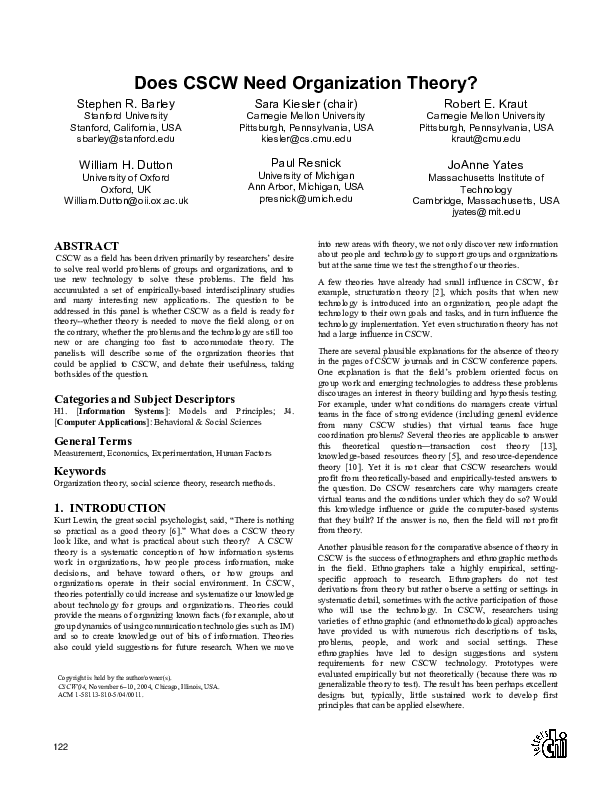

In [65]:
WImage(filename="../data/pdfs/2004/p122-kiesler.pdf")

In [66]:
print(merged_df.loc['2004/p122-kiesler']['paper_text'][550:1350])

ge, Massachusetts, USA jyates@mit.edu

  ABSTRACT

  CSCW as a field has been driven primarily by researchers’ desire to
  solve real world problems of groups and organizations, and to use new
  technology to solve these problems. The field has accumulated a set of
  empirically-based interdisciplinary studies and many interesting new
  applications. The question to be addressed in this panel is whether
  CSCW as a field is ready for theory--whether theory is needed to move
  the field along, or on the contrary, whether the problems and the
  technology are still too new or are changing too fast to accommodate
  theory. The panelists will describe some of the organization theories
  that could be applied to CSCW, and debate their usefulness, taking
  both sides of the question.



CATEGORI


In [67]:
merged_df.drop(labels=['2004/p122-kiesler'], inplace=True)

### Remove extended abstracts, mostly from CSCW 2011

Panel descriptions in the extended abstract format have substantially fewer words per page. These are usually in landscape format (orientation = 90), but some are also in portrait (orientation = 0). We're going to figure out what the threshold is for extended abstracts. 

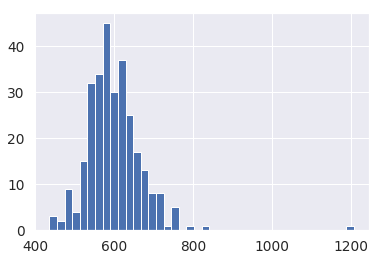

In [68]:
merged_df.query("year_float > 2017").words_per_page.hist(bins=40)

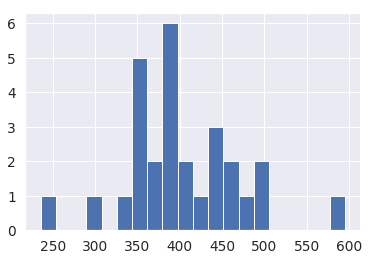

In [69]:
merged_df.query("year_float == 2011 & orientation == 90").words_per_page.hist(bins=20)

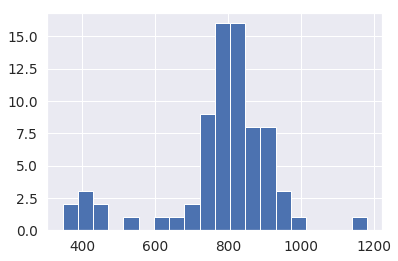

In [70]:
merged_df.query("year_float == 2011 & orientation == 0").words_per_page.hist(bins=20)

In [71]:
merged_df.query("year_float == 2011 & orientation == 0").sort_values('words_per_page')[['words_per_page']].head(20)

,words_per_page
filename,
2011/p653-jung,345.500000
2011/p597-bednarik,377.750000
2011/p601-bouwer,397.250000
2011/p633-groth,398.750000
2011/p661-kanai,427.500000
2011/p593-bagalkot,443.750000
2011/p665-kwon,458.250000
2011/p709-schwanda,519.750000
2011/p151-hu,607.142857


Extended abstracts are generally less than 500 words/page, but what's going on with these ~400 word/page abstracts? Lets look at the PDF for the one with the fewest words/page:

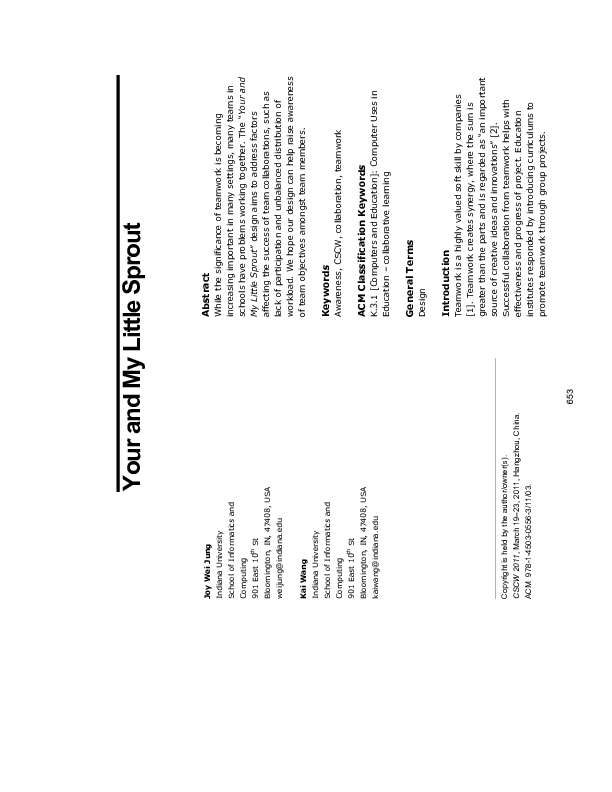

In [72]:
WImage(filename="../data/pdfs/2011/p653-jung.pdf")

Oh no, we can't trust orientation to be a proxy for extended abstract vs paper/note! We'll have to filter by some kind of threshold. 

In [73]:
merged_df.query("year_float == 2011 & orientation == 90").sort_values('words_per_page')[['words_per_page','num_pages']]

,words_per_page,num_pages
filename,,
2011/p605-bouzasal,235.75,4
2011/p689-mistry,307.50,4
2011/p637-guibourdenche,336.00,4
2011/p669-liu,345.00,4
2011/p677-masih,347.75,4
2011/p609-bowie,348.25,4
2011/p657-kamran,355.50,4
2011/p645-ho,358.50,4
2011/p697-perezpelaez,368.75,4


Before we begin, let's make sure that last extended abstract is actually an EA and not a note in landscape orientation:

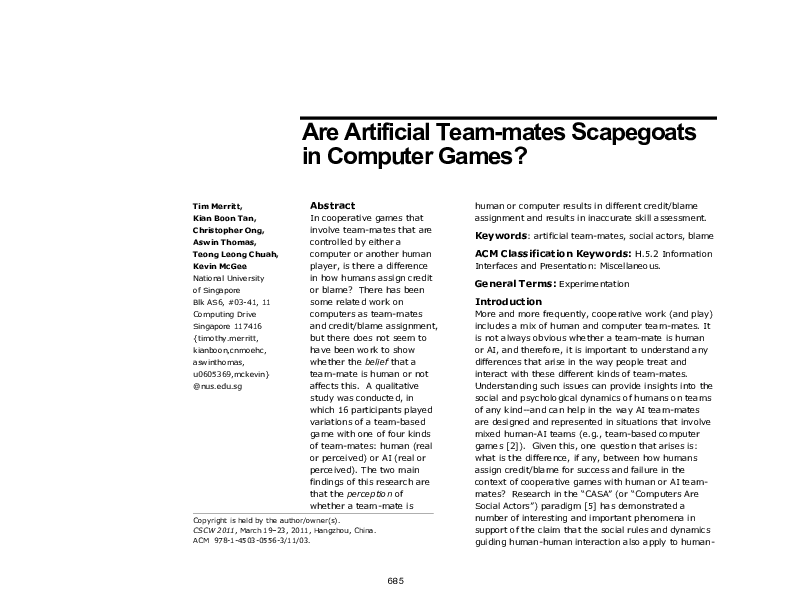

In [74]:
WImage(filename="../data/pdfs/2011/p685-merritt.pdf")


Whew! Let's go back to that list of papers ordered by words/page for landscape orientation and do some spot checking around the 500-600 words/page break:

In [75]:
merged_df.query("year_float == 2011 & orientation == 0").sort_values('words_per_page')[['words_per_page']].head(20)

,words_per_page
filename,
2011/p653-jung,345.500000
2011/p597-bednarik,377.750000
2011/p601-bouwer,397.250000
2011/p633-groth,398.750000
2011/p661-kanai,427.500000
2011/p593-bagalkot,443.750000
2011/p665-kwon,458.250000
2011/p709-schwanda,519.750000
2011/p151-hu,607.142857


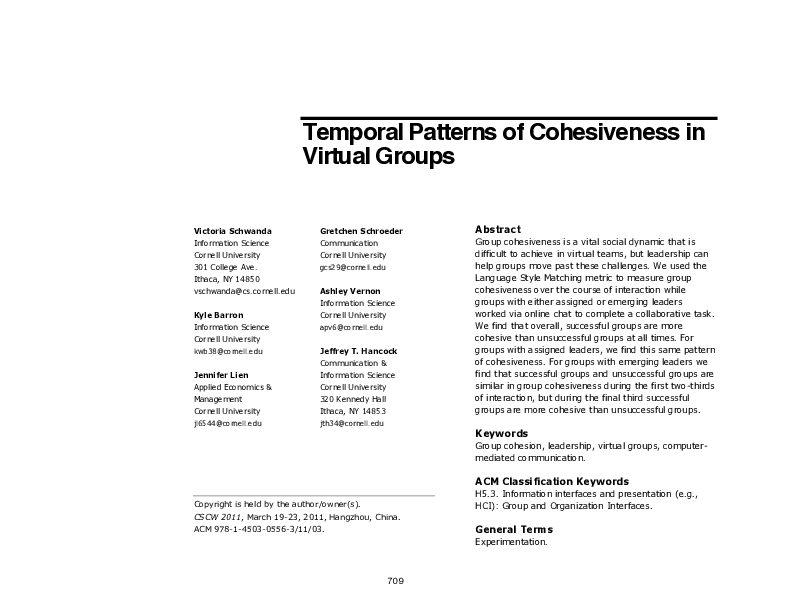

In [76]:
WImage(filename="../data/pdfs/2011/p709-schwanda.pdf")


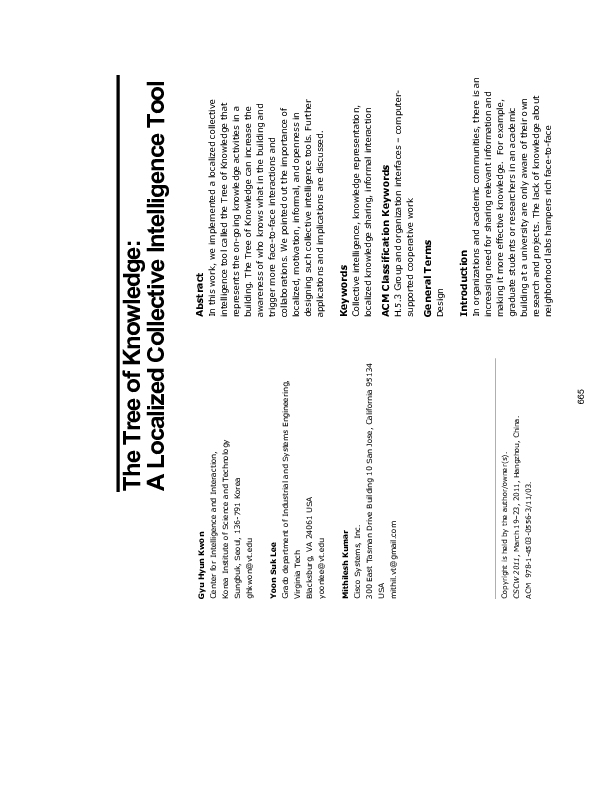

In [77]:
WImage(filename="../data/pdfs/2011/p665-kwon.pdf")


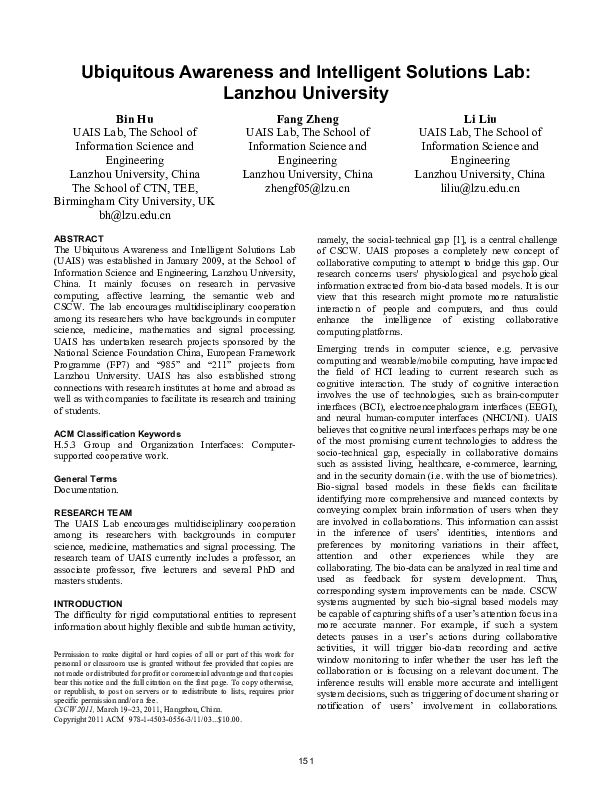

In [78]:
WImage(filename="../data/pdfs/2011/p151-hu.pdf")


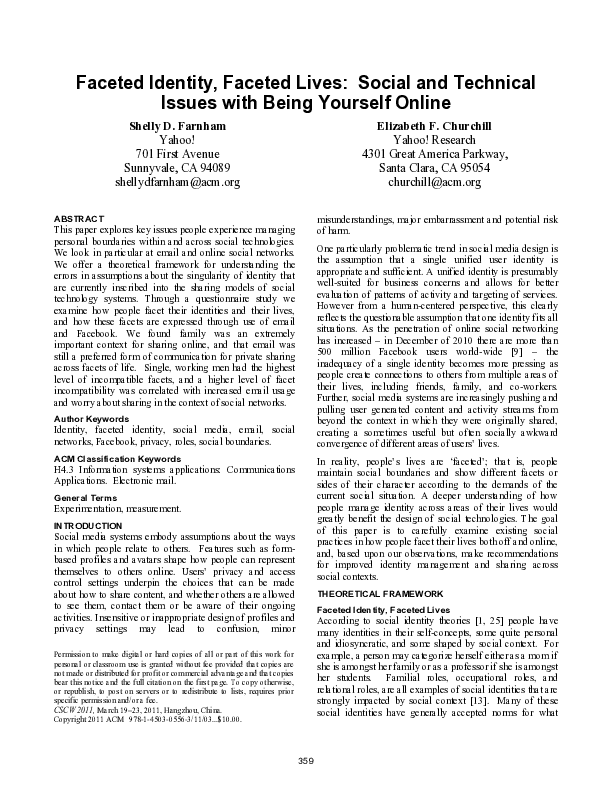

In [79]:
WImage(filename="../data/pdfs/2011/p359-farnham.pdf")


OK! Looks like we have a pretty good threshold at 520 words/page: everything below is an extended abstact, everything above is a note.

In [80]:
len(merged_df)

1669

In [81]:
merged_df.year_float.value_counts()

2018.0    185
2017.0    183
2012.0    164
2015.0    161
2016.0    140
2013.0    139
2014.0    134
2017.5    105
2011.0    102
2008.0     86
2004.0     75
2006.0     61
2010.0     58
2002.0     39
2000.0     36
2019.0      1
Name: year_float, dtype: int64

In [82]:
merged_df_all = merged_df

In [83]:
merged_df = merged_df.query("orientation != 90")

In [84]:
merged_df = merged_df.query("(year_float > 2017) | (year_float < 2017.5 & words_per_page > 520)")

In [85]:
counts_before = pd.DataFrame(merged_df_all.year.value_counts()).sort_index()
counts_before.index = counts_before.index.astype(float)

In [86]:
counts_after = pd.DataFrame(merged_df.year_float.value_counts()).sort_index()

In [87]:
combi = pd.concat([counts_before,counts_after], axis=1)
combi.columns = ['before','after']
combi

,before,after
2000.0,36,36
2002.0,39,39
2004.0,75,75
2006.0,61,61
2008.0,86,86
2010.0,58,58
2011.0,102,66
2012.0,164,164
2013.0,139,139
2014.0,134,134


## Get title and lead author

In [88]:
def get_title(text):
    
    head = text[0:300]
    
    if head[0:1] == "\n":
        head = head[1:]

    if head[0:1] == "\n":
        head = head[1:]
    
    
    if len(head.split("\n\n")[0]) > 25:
        base = head.split("\n\n")[0]
    elif len(head.split("\n")[0]) > 25:
        base = head.split("\n")[0]
    elif len(head.split("\n\n")[0] + head.split("\n\n")[1]) > 25:
        base = head.split("\n\n")[0] + head.split("\n\n")[1]
    else:
        base = head.split("\n")[0] + head.split("\n")[1]
        
    title = re.sub("\s+"," ",base.replace("\n", " ").title())
    
    if 'abstract' in title.lower()[0:12]:
        title = title[title.lower().find('abstract')+9:]
        
    if title[0:2] == '[]':
        title = title[2:]
        
    return title

In [89]:
get_title(merged_df.loc['2010/p117-geiger'].paper_text)

'The Work Of Sustaining Order In Wikipedia: The Banning Of A Vandal'

In [90]:
pd.DataFrame(merged_df['paper_text'].sample(50).apply(get_title))

,paper_text
filename,
2014/p1283-hwang,Talkbetter: Family-Driven Mobile Intervention...
2000/p181-mauve,Consistency In Replicated Continuous Interact...
2017.5/a100-tausczik,"To Share, Or Not To Share? Community-Level Co..."
2017/p1217-cheng,Anyone Can Become A Troll:
2013/p741-snyder,Drawing Practices In Image-Enabled Collaboration
2015/p276-paay,Connecting In The Kitchen: An Empirical Study...
2018/cscw106-li,[]Out Of Site: Empowering A New Approach To O...
2004/p212-beenen,Using Social Psychology To Motivate Contribut...
2015/p1682-zyskowski,Accessible Crowdwork? Understanding The Value...


In [91]:
merged_df['title_from_text'] = pd.DataFrame(merged_df.paper_text.apply(get_title))

In [93]:
def get_lead_author(filename):
    
    if filename.split('/')[0] != '2016':
        return filename[len(filename.split('-')[0])+1:]
    else:
        return filename[len(filename.split('_')[0])+1:]
        

In [94]:
merged_df['lead_author'] = merged_df.index.map(get_lead_author)

In [95]:
merged_df['lead_author'].sample(50)

filename
2014/p1400-grevet                          grevet
2018/cscw051-feuston                      feuston
2006/p459-razavi                           razavi
2002/p266-lutters                         lutters
2006/p505-avrahami                       avrahami
2018/cscw197-zhang                          zhang
2012/p613-kow                                 kow
2013/p1301-kittur                          kittur
2012/p843-xu                                   xu
2012/p969-fugelstad                     fugelstad
2016/288_goyal                              goyal
2017/p2010-kokkalis                      kokkalis
2000/p145-singley                         singley
2017/p468-yim                                 yim
2017/p1444-zhao                              zhao
2017/p1049-arciniegas-mendez    arciniegas-mendez
2011/p331-munson                           munson
2004/p614-dimicco                         dimicco
2010/p421-hartmann                       hartmann
2017.5/a041-dosono                       

### Does the title have a quotation mark?

In [96]:
def title_has_quote(title):
    if '“' in title:
        return 1
    elif '”' in title:
        return 1
    elif '"' in title:
        return 1
    elif "''" in title:
        return 1
    else:
        return 0

In [97]:
merged_df['title_has_quote'] = merged_df['title_from_text'].apply(title_has_quote)
merged_df[['title_has_quote','title_from_text']].sort_values('title_has_quote', ascending=False)

,title_has_quote,title_from_text
filename,,
2015/p302-wisniewski,1,“Preventative” Vs. “Reactive”: How Parental M...
2015/p1788-ringland,1,Making “Safe”: Community-Centered Practices I...
2017.5/a033-chounta,1,When To Say “Enough Is Enough!”: A Study On T...
2012/p47-sarcevic,1,“Beacons Of Hope” In Decentralized Coordinati...
2017/p2273-mazmanian,1,"“Okay, One More Episode”: An Ethnography Of P..."
2017.5/a113-xia,1,“Our Privacy Needs To Be Protected At All Cos...
2011/p341-newman,1,"“It'S Not That I Don'T Have Problems, I'M Jus..."
2018/cscw087-kelly,1,“It’S More Like A Leter”: An Exploration Of M...
2012/p965-quercia,1,Tracking “Gross Community Happiness” From Tweets


## Stats for "The Rise and Fall of the Note" in CSCW 2019

In [98]:
merged_df.query("year_float == 2019").T

filename,2019/geiger-cscw19-notes
words,5737
year_float,2019
characters,39522
num_pages,10
orientation,NaN
year,2019
words_per_page_total,573.7
chars_per_word_total,6.88897
paper_text,THE RISE AND FALL OF THE NOTE: CHANGING PAPE...
appx_start,False


## Export

In [99]:
merged_df.query("year_float != 2019").to_csv("../data/cscw-pages-all.csv")

In [100]:
merged_df.query("year_float != 2019").drop(['ref_text', 'appx_text', 'paper_text'], axis=1).to_csv("../data/cscw-pages-notext.csv")

In [101]:
end = datetime.datetime.now()

time_to_run = end - start
minutes = int(time_to_run.seconds/60)
seconds = time_to_run.seconds % 60
print("Total runtime: ", minutes, "minutes, ", seconds, "seconds")

Total runtime:  11 minutes,  15 seconds
